<a href="https://colab.research.google.com/github/lucasdnk/MVP-puc/blob/main/MVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INTRODUÇÃO
Neste trabalho sera feito um modelo preditivo de machine learning a partir de um banco de dados referente as campanhas de marketing de um Banco portugues com abordagem direta (ligacoes telefonicas), com objetivo de venda de titulos bancarios.
O valor deste modelo esta no aprimoramento da estrategia de venda, identificando os perfis de clientes que aderem a esta modalidade de investimento pode-se organizar a prioridade dos contatos aumentando a eficacia do marketing.


## primeiramente importamos as bibliotecas a serem utilizadas


In [26]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # para medir precisao, acuracia e recall do modelo
from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVM
from sklearn.preprocessing import LabelEncoder # para transformar os labels em números
from sklearn.linear_model import LogisticRegression #algoritmo de regressao logistica
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest # para a Seleção Univariada
from sklearn.feature_selection import f_classif # para o teste ANOVA da Seleção Univariada
from sklearn.feature_selection import RFE # para a Eliminação Recursiva de Atributos

from google.colab import drive

### criando datasets pandas a partir do arquivo 'bank-full.csv'

In [8]:
db = pd.read_csv(r'https://raw.githubusercontent.com/lucasdnk/MVP-puc/refs/heads/main/bank-full.csv', sep=';')# https://www.kaggle.com/datasets/mahdiehhajian/bank-marketing


## visualizar o dataset criado

In [9]:
display(db)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


# O DATASET

## traduzindo o dataset
como o dataset foi elaborado em ingles, optei por traduzi-lo para facilitar a compreensão

In [10]:
db.columns = ['idade', 'emprego', 'estado_civil', 'educacao', 'default', 'balanco_medio_anual', 'hipoteca', 'emprestimo_pessoal', 'contato', 'dia', 'mes', 'duracao_chamada', 'qtd_contatos', 'dias_ultimo_contato', 'qtd_contatos_total', 'campanha_anterior', 'resultado']


In [11]:
display(db['emprego'].unique(),
db['estado_civil'].unique(),
db['educacao'].unique(),
db['default'].unique(),
db['hipoteca'].unique(),
db['emprestimo_pessoal'].unique(),
db['contato'].unique(),
db['campanha_anterior'].unique())


array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin.', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

array(['married', 'single', 'divorced'], dtype=object)

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['yes', 'no'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['unknown', 'cellular', 'telephone'], dtype=object)

array(['unknown', 'failure', 'other', 'success'], dtype=object)

In [12]:
# traducao dos empregos
traducao_empregos = {
    'management': 'gerência',
    'technician': 'técnico',
    'entrepreneur': 'empreendedor',
    'blue-collar': 'operário',
    'unknown': 'desconhecido',
    'retired': 'aposentado',
    'admin.': 'administrativo',
    'services': 'serviços',
    'self-employed': 'autônomo',
    'unemployed': 'desempregado',
    'housemaid': 'empregado_doméstico',
    'student': 'estudante'
}

# Tradução do estado civil
traducao_estado_civil = {
    'married': 'casado',
    'single': 'solteiro',
    'divorced': 'divorciado',
    'unknown': 'desconhecido'
}

# Tradução da educação
traducao_educacao = {
    'tertiary': 'superior',
    'secondary': 'secundário',
    'unknown': 'desconhecido',
    'primary': 'primário'
}

# Tradução default
traducao_default = {
    'yes': 'sim',
    'no': 'não',
    'unknown': 'desconhecido'
}

# Tradução hipoteca e empréstimo pessoal
traducao_sim_nao = {
    'yes': 'sim',
    'no': 'não'
}

# Tradução tipo de contato
traducao_contato = {
    'unknown': 'desconhecido',
    'cellular': 'celular',
    'telephone': 'telefone'
}

# Tradução resultado da campanha anterior
traducao_campanha = {
    'unknown': 'desconhecido',
    'failure': 'falha',
    'other': 'outro',
    'success': 'sucesso'
}
# traduzir o resultado
traducao_resultado = {
    'yes': 'sim',
    'no': 'não'
}

# Aplicar todas as traduções
db['emprego'] = db['emprego'].map(traducao_empregos)
db['estado_civil'] = db['estado_civil'].map(traducao_estado_civil)
db['educacao'] = db['educacao'].map(traducao_educacao)
db['default'] = db['default'].map(traducao_default)
db['hipoteca'] = db['hipoteca'].map(traducao_sim_nao)
db['emprestimo_pessoal'] = db['emprestimo_pessoal'].map(traducao_sim_nao)
db['contato'] = db['contato'].map(traducao_contato)
db['campanha_anterior'] = db['campanha_anterior'].map(traducao_campanha)
db['resultado'] = db['resultado'].map(traducao_resultado)

# Verificar o resultado
for coluna in ['emprego', 'estado_civil', 'educacao', 'default', 'hipoteca', 'emprestimo_pessoal', 'contato', 'campanha_anterior']:
    print(f"\nValores únicos em {coluna}:")
    print(db[coluna].unique())



Valores únicos em emprego:
['gerência' 'técnico' 'empreendedor' 'operário' 'desconhecido'
 'aposentado' 'administrativo' 'serviços' 'autônomo' 'desempregado'
 'empregado_doméstico' 'estudante']

Valores únicos em estado_civil:
['casado' 'solteiro' 'divorciado']

Valores únicos em educacao:
['superior' 'secundário' 'desconhecido' 'primário']

Valores únicos em default:
['não' 'sim']

Valores únicos em hipoteca:
['sim' 'não']

Valores únicos em emprestimo_pessoal:
['não' 'sim']

Valores únicos em contato:
['desconhecido' 'celular' 'telefone']

Valores únicos em campanha_anterior:
['desconhecido' 'falha' 'outro' 'sucesso']


# DIVIDINDO OS DADOS


## ATRIBUTOS(X)
### ESTE SAO OS DADOS DE ENTRADA COM OS QUAIS TRABALHEMOS PARA FAZER AS PREDICOES
1. idade: Idade do cliente (numérico)
2. emprego: Ocupação do cliente (gerência, técnico, empreendedor, operário, desconhecido, aposentado, administrativo, serviços, autônomo, desempregado, empregado_doméstico, estudante)
3. estado_civil: Estado civil do cliente (casado, solteiro, divorciado, desconhecido)
4. educacao: Nível de educação (superior, secundário, primário, desconhecido)
5. default: Cliente tem crédito em default (sim, não, desconhecido)
6. balanco_medio_anual: Saldo médio anual em euros (numérico)
7. hipoteca: Cliente possui empréstimo habitacional (sim, não)
8. emprestimo_pessoal: Cliente possui empréstimo pessoal (sim, não)
9. contato: Tipo de contato realizado (celular, telefone, desconhecido)
10. dia: Último dia de contato do mês (numérico: 1-31)
11. mes: Último mês de contato do ano (categórico: jan-dez)
12. duracao_chamada: Duração do último contato em segundos (numérico)
13. qtd_contatos: Número de contatos realizados durante esta campanha (numérico)
14. dias_ultimo_contato: Número de dias desde o último contato (numérico)
15. qtd_contatos_total: Número de contatos realizados antes desta campanha (numérico)
16. campanha_anterior: Resultado da campanha anterior (sucesso, falha, outro, desconhecido)

## ALVO(Y)
17. resultado: Resultado da campanha atual - variável alvo (sim, não)

# DADOS ESTATISTICOS DOS PARAMETROS NUMERICOS
uma checagem rapida procurando possiveis erros no dataset


In [13]:
display(db.isnull().sum())
display(db.select_dtypes(include=['int64', 'float64']).describe())

,0
idade,0
emprego,0
estado_civil,0
educacao,0
default,0
balanco_medio_anual,0
hipoteca,0
emprestimo_pessoal,0
contato,0
dia,0


,idade,balanco_medio_anual,dia,duracao_chamada,qtd_contatos,dias_ultimo_contato,qtd_contatos_total
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


# <span style="color: red">INICIO DO PROJETO</span>

## Preparação dos dados

A biblioteca sklearn trabalha apenas com parametros numericos, portanto e feita uma conversao dos valores para um numeros correspondentes.


In [14]:
# Criar dicionário para armazenar os encoders e legendas
encoders = {}
legendas = {}

# Identificar colunas categóricas
colunas_categoricas = ['emprego', 'estado_civil', 'educacao', 'default',
                      'hipoteca', 'emprestimo_pessoal', 'contato', 'mes',
                      'campanha_anterior', 'resultado']

# Converter cada coluna categórica e salvar a legenda
for coluna in colunas_categoricas:
    # Criar e ajustar o encoder
    le = LabelEncoder()
    db[coluna] = le.fit_transform(db[coluna])

    # Salvar o encoder e criar legenda
    encoders[coluna] = le
    legendas[coluna] = dict(zip(le.classes_, le.transform(le.classes_)))

# Imprimir as legendas para referência
print("LEGENDAS DAS CONVERSÕES:")
for coluna, legenda in legendas.items():
    print(f"\n{coluna.upper()}:")
    for categoria, numero in legenda.items():
        print(f"{categoria}: {numero}")


LEGENDAS DAS CONVERSÕES:

EMPREGO:
administrativo: 0
aposentado: 1
autônomo: 2
desconhecido: 3
desempregado: 4
empreendedor: 5
empregado_doméstico: 6
estudante: 7
gerência: 8
operário: 9
serviços: 10
técnico: 11

ESTADO_CIVIL:
casado: 0
divorciado: 1
solteiro: 2

EDUCACAO:
desconhecido: 0
primário: 1
secundário: 2
superior: 3

DEFAULT:
não: 0
sim: 1

HIPOTECA:
não: 0
sim: 1

EMPRESTIMO_PESSOAL:
não: 0
sim: 1

CONTATO:
celular: 0
desconhecido: 1
telefone: 2

MES:
apr: 0
aug: 1
dec: 2
feb: 3
jan: 4
jul: 5
jun: 6
mar: 7
may: 8
nov: 9
oct: 10
sep: 11

CAMPANHA_ANTERIOR:
desconhecido: 0
falha: 1
outro: 2
sucesso: 3

RESULTADO:
não: 0
sim: 1


# TREINAMENTO DO MODELO



primeiramente separamos os valores em valores de treino, e valores de teste,
particionamos os dados em 10 folds para validacao cruzada e definimos a acuracia como metrica de avaliacao


In [15]:
# Separação em bases de treino e teste (holdout)
array = db.values
X = array[:,0:16] # atributos
y = array[:,16] # classe (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7) # faz a divisão

# Criando os folds para a validação cruzada
scoring = 'accuracy' # métrica de avaliação
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds

In [16]:
# Definindo uma seed global para esta célula de código
np.random.seed(7)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('LR', LogisticRegression(max_iter=200)))

In [17]:
# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) # média e desvio padrão dos 10 resultados da validação cruzada
  print(msg)

KNN: 0.883294 (0.004707)
CART: 0.871599 (0.005050)
NB: 0.853765 (0.007359)
SVM: 0.881636 (0.002997)
LR: 0.890041 (0.003034)


## comparacao dos modelos
aqui comparamos o modelo para escolhermos o de melhor acuracia

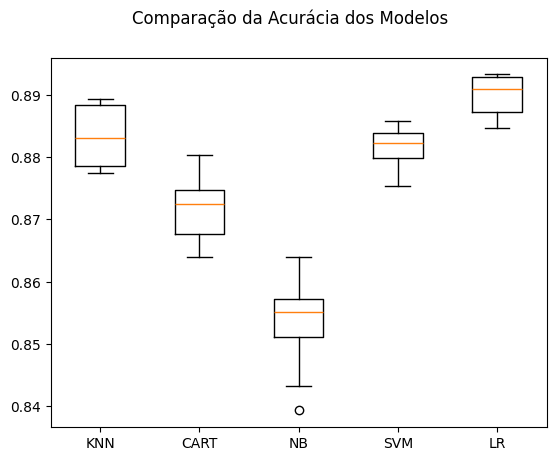

In [18]:
# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação da Acurácia dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Dentre os modelos criados, o que apresentou melhor acuracia foi o de Regressao Logistica, apesar do KNN (k = 5) ter apresentado um resultado proximo

In [19]:
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))

0.8943934534999447


verificando o modelo KNN com diferentes valores de k para testar se supera o de regressao logistica

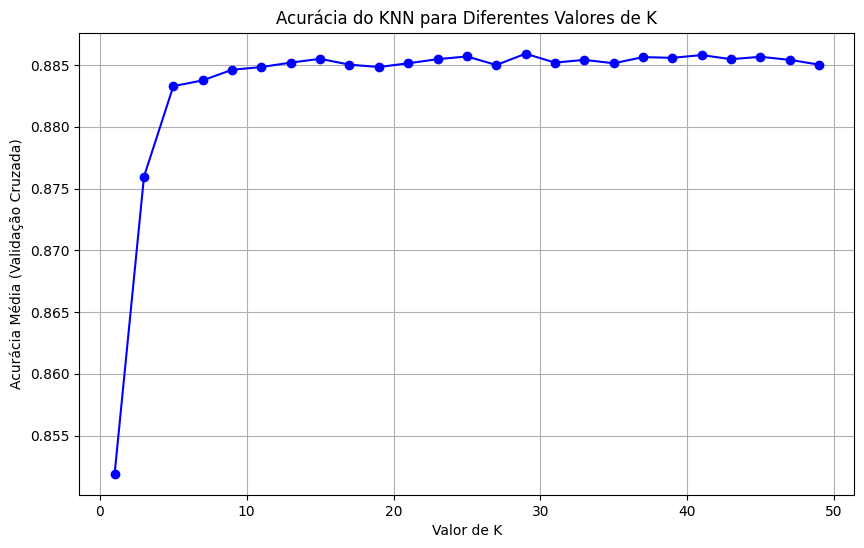

Melhor valor de K: 29
Melhor acurácia: 0.8859


In [20]:
# Testando diferentes valores de K
k_valores = range(1, 51, 2)  # Testando valores ímpares de K de 1 a 50
k_scores = []

for k in k_valores:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Usando validação cruzada para cada valor de K
    scores = cross_val_score(knn, X_train, y_train, cv=kfold, scoring='accuracy')
    k_scores.append(scores.mean())

# Plotando os resultados
plt.figure(figsize=(10, 6))
plt.plot(k_valores, k_scores, 'bo-')
plt.title('Acurácia do KNN para Diferentes Valores de K')
plt.xlabel('Valor de K')
plt.ylabel('Acurácia Média (Validação Cruzada)')
plt.grid(True)
plt.show()

# Encontrando o melhor K
best_k = k_valores[k_scores.index(max(k_scores))]
print(f'Melhor valor de K: {best_k}')
print(f'Melhor acurácia: {max(k_scores):.4f}')


O boxplot mostra que a LR tem uma distribuição de acurácia mais consistente (menor variância)
O KNN, mesmo após a otimização do K, não mostrou uma melhoria significativa em relação à LR
Portanto, a LR é o modelo escolhido para a classificação

#ENSEMBLES
aqui e testado os metodos ensembles utilizados nas aulas do curso para possivelmente aprimorar a sua acuracia

KNN: 0.883294 (0.004707)
CART: 0.871682 (0.004874)
NB: 0.853765 (0.007359)
SVM: 0.881636 (0.002997)
LR: 0.890041 (0.003034)
Bagging: 0.902842 (0.005458)
RF: 0.903257 (0.002900)
ET: 0.899331 (0.003194)
Ada: 0.899110 (0.002631)
GB: 0.902787 (0.003682)
Voting: 0.886308 (0.002098)


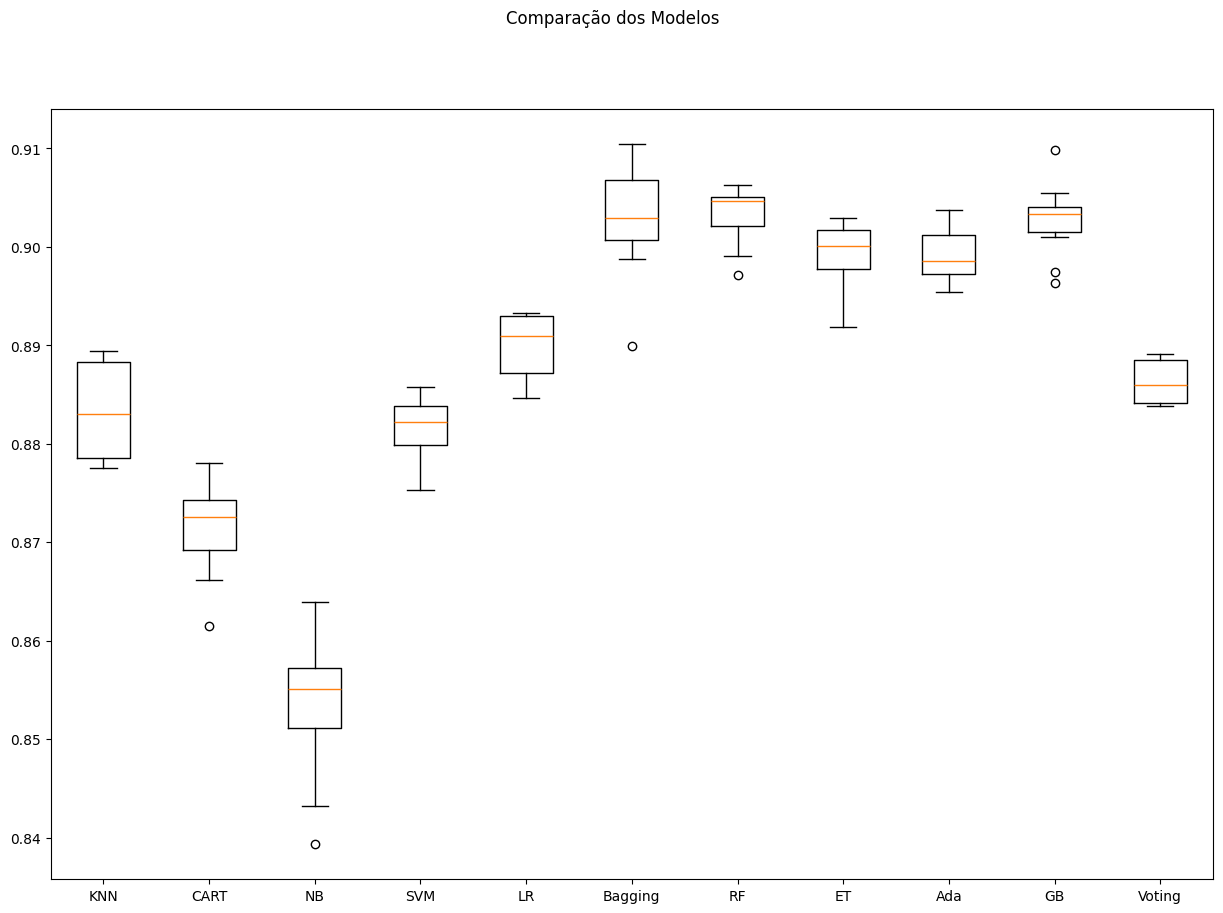

In [22]:
# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = KNeighborsClassifier(n_neighbors=best_k)
bases.append(('KNN', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

podemos ver uma melhora nos resultados, assim definindo o uso do Random Forest como modelo

In [ ]:
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Calculando múltiplas métricas
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Imprimindo os resultados
print(f'Acurácia: {accuracy:.4f}')
print(f'Precisão: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# FEATURE SELECTION

primeiro foi feito um rankeamento das importancias dos atributos

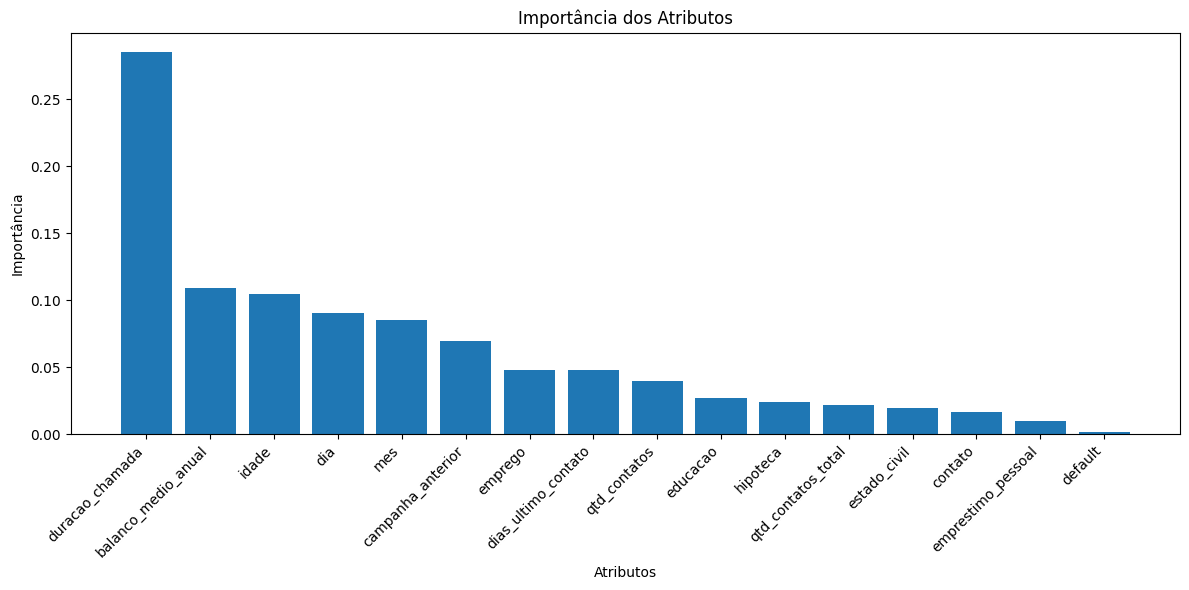

In [24]:
feature_names = ['idade', 'emprego', 'estado_civil', 'educacao', 'default',
                'balanco_medio_anual', 'hipoteca', 'emprestimo_pessoal',
                'contato', 'dia', 'mes', 'duracao_chamada', 'qtd_contatos',
                'dias_ultimo_contato', 'qtd_contatos_total', 'campanha_anterior']

# Criar e treinar o modelo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Obter a importância das features
importances = rf_model.feature_importances_

# Criar um DataFrame com as importâncias
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Ordenar por importância
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plotar um gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Importância dos Atributos')
plt.xlabel('Atributos')
plt.ylabel('Importância')
plt.tight_layout()
plt.show()

# Imprimir os valores
print("\nImportância de cada atributo:")
for idx, row in feature_importance_df.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

aqui faremos uma exclusao dos atributos de menor importancia e testamos o modelo

In [27]:
db2 = db.drop('default', axis=1)
array = db2.values
X = array[:,0:15] # atributos
y = array[:,15] # classe (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7) # faz a divisão

model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Calculando múltiplas métricas
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Imprimindo os resultados
print(f'Acurácia: {accuracy:.4f}')
print(f'Precisão: {precision:.4f}')
print(f'Recall: {recall:.4f}')


Acurácia: 0.9082
Precisão: 0.6388
Recall: 0.4213


o atributo default foi removido sem perdas significativas para o modelo

In [28]:
db3 = db2.drop('emprestimo_pessoal', axis=1)
array = db3.values
X = array[:,0:14] # atributos
y = array[:,14] # classe (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7) # faz a divisão


model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Calculando múltiplas métricas
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Imprimindo os resultados
print(f'Acurácia: {accuracy:.4f}')
print(f'Precisão: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Acurácia: 0.9090
Precisão: 0.6496
Recall: 0.4124


removendo o atributo 'emprestimo_pessoal' continuamos sem perdas

In [29]:
db4 = db3.drop('contato', axis=1)
array = db4.values
X = array[:,0:13] # atributos
y = array[:,13] # classe (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7) # faz a divisão
# Listas para armazenar os modelos, os resultados e os nomes dos modelos

model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Calculando múltiplas métricas
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Imprimindo os resultados
print(f'Acurácia: {accuracy:.4f}')
print(f'Precisão: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Acurácia: 0.9083
Precisão: 0.6441
Recall: 0.4114


In [31]:
db5 = db4.drop('estado_civil', axis=1)
array = db5.values
X = array[:,0:12] # atributos
y = array[:,12] # classe (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7) # faz a divisão
# Listas para armazenar os modelos, os resultados e os nomes dos modelos

model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Calculando múltiplas métricas
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Imprimindo os resultados
print(f'Acurácia: {accuracy:.4f}')
print(f'Precisão: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Acurácia: 0.9073
Precisão: 0.6332
Recall: 0.4163


ao removermos o atributo 'estado_civil' ja podemos ver uma perda de acuracia.